# PyTF Example: Realtime Filtering

In [1]:
import os, sys
path = os.path.realpath(os.path.join(os.getcwd(), '..'))
sys.path.append(path)

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


import numpy as np
from mu import core
from mu import FilterBank

from mspacman.generator.noise import (white, pink) # I can't share this repository yet until my paper is published.
# So in order to make this example to work on your local machine, try generating your own test signal.

## Generate Signal

In [2]:
# Properties
tdur = 20
fs = 30000
nsamp = fs * tdur

# f = np.linspace(0, 100, nsamp)
f = 100

amp = .5
# Generate a time domain signal
t = np.linspace(0, tdur, nsamp)
x = np.sin(f * 2 * np.pi * t)

In [3]:
binsize = int(fs * .25)
update = int(binsize * .15)
x_ = core.frame(x, binsize=binsize, hopsize=update)
t_ = core.frame(t, binsize=binsize, hopsize=update)

In [4]:
center_freqs = np.array([100])
bandwidth = 50
freq_bands = None
# binsize = 2048
dec = 4 # can't be greater than specified, since we're limited to the binsize specified binsize
fb = FilterBank(nch=1, nsamp=binsize, binsize=1024, decimate_by=dec, \
                bandwidth=bandwidth, center_freqs=center_freqs, freq_bands=freq_bands, order=1024, sample_rate=fs, \
                hilbert=False, domain='time', nprocs=1, mprocs=False, zero_phase=True,
                logger=None)

<IPython.core.display.Javascript object>


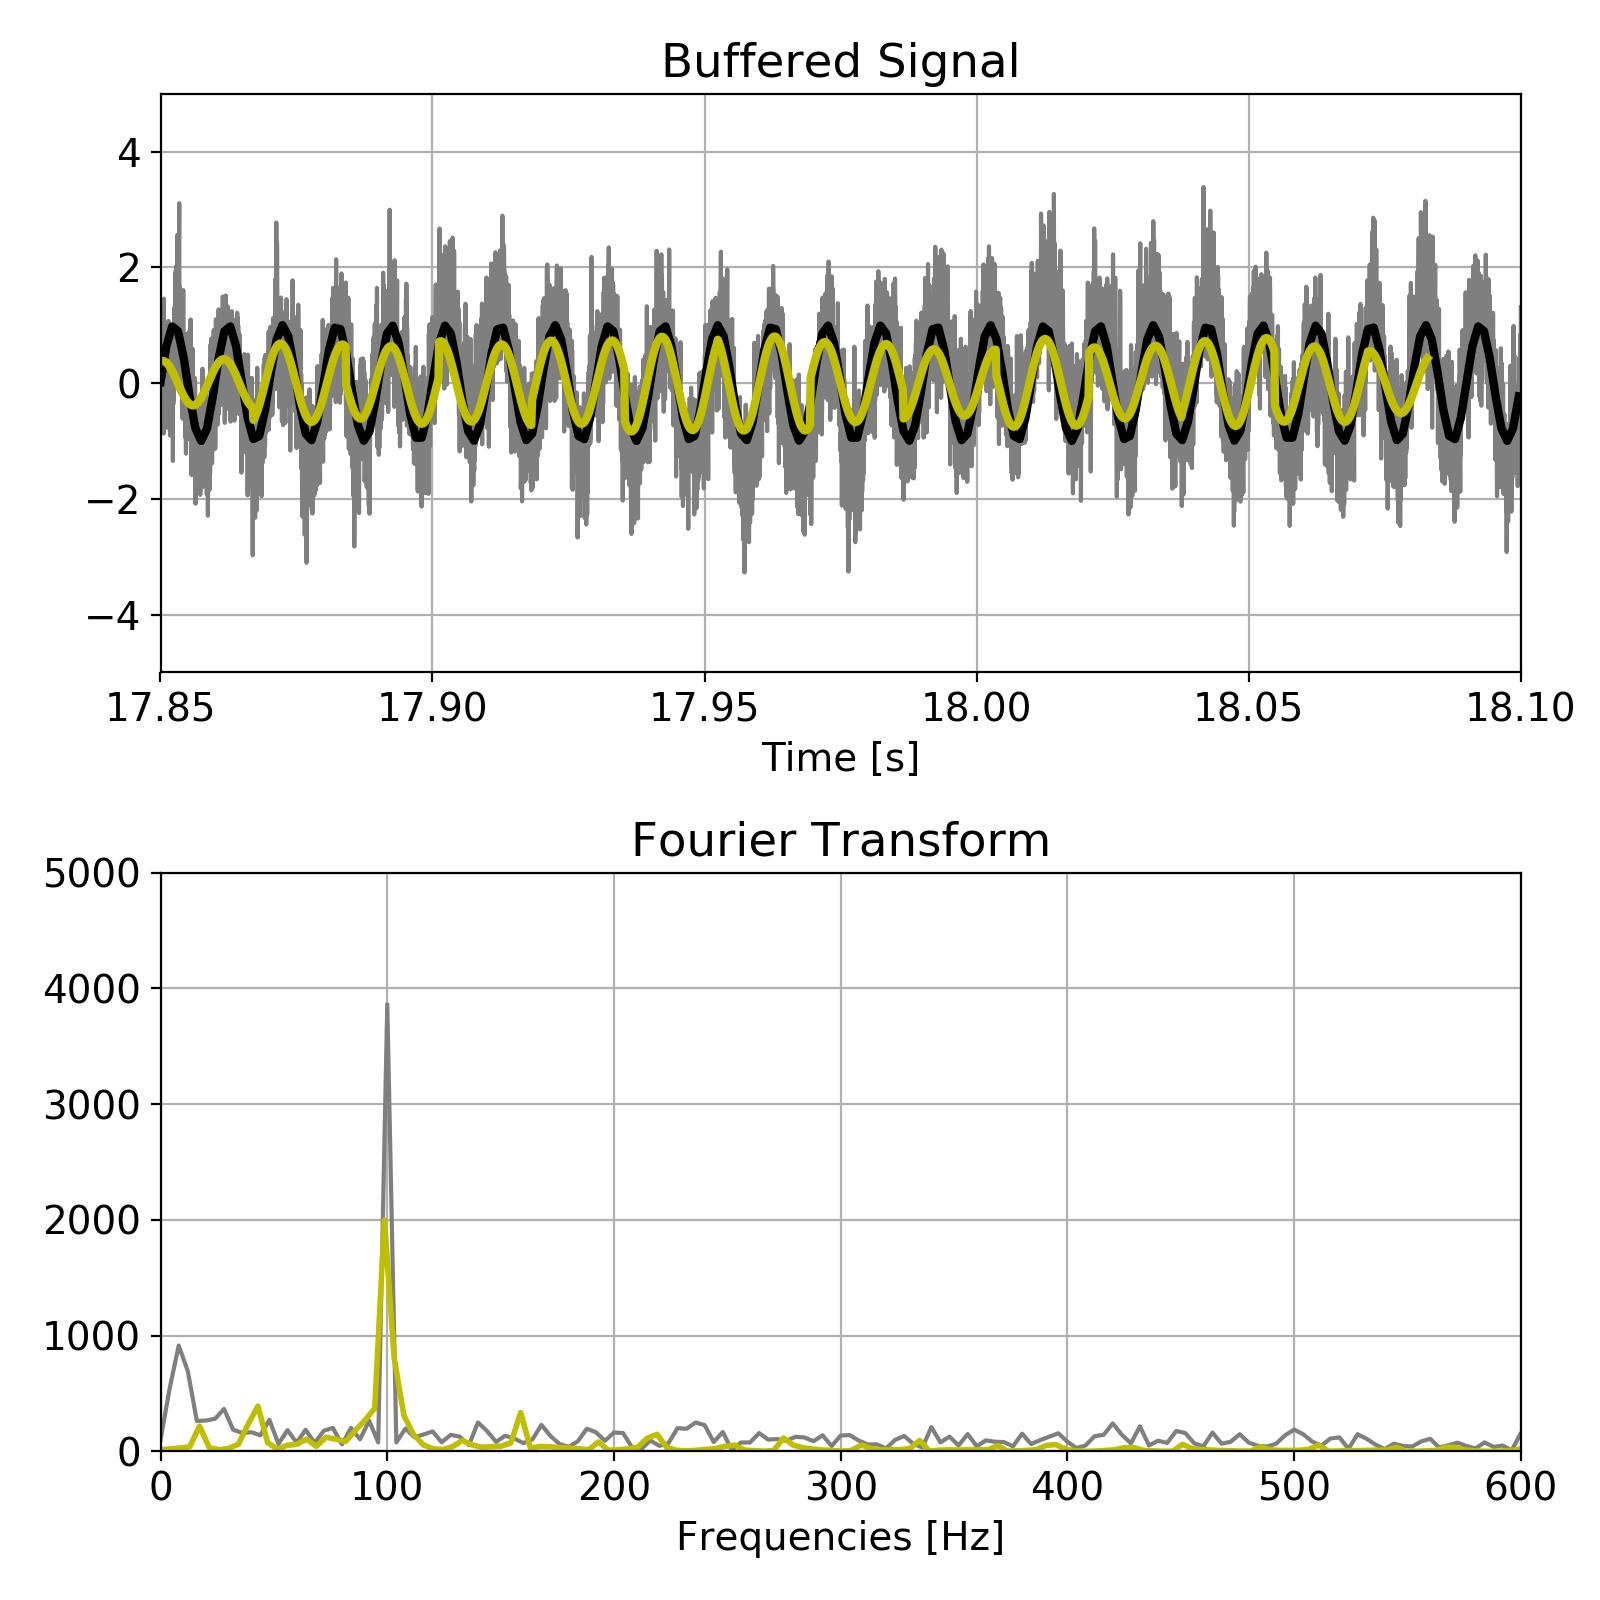

In [6]:
%matplotlib notebook

amp = .5
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

line, = axs[0].plot(np.arange(binsize)/fs, np.zeros(binsize)*np.nan, c='C7')
line2, = axs[0].plot(np.arange(binsize)/fs, np.zeros(binsize)*np.nan, c='k', lw=3)
line3, = axs[0].plot(np.arange(binsize)/fs, np.zeros(binsize)*np.nan, c='y', lw=3)
line_, = axs[1].plot(np.arange(binsize)/fs, np.zeros(binsize)*np.nan, c='C7')
line2_, = axs[1].plot(np.arange(binsize)/fs, np.zeros(binsize)*np.nan, c='y', lw=2)


axs[1].set_ylim(0, 5E3)
axs[0].grid(True)
axs[1].grid(True)
def animate(i):
    _t, _x = t_[0, i, :], x_[0, i, :]
    n_ = (white(_x.size, mean=0, std=amp) + pink(_x.size, mean=0, std=amp)).flatten()
    _xn_ = _x + n_
    
    _xf_ = fb.analysis(np.atleast_2d(_xn_), window='hanning')[0,:(binsize-512)//dec].flatten()

    _Xn_ = np.fft.rfft(_xn_, axis=-1)
    _Xf_ = np.fft.rfft(_xf_, axis=-1)
    
    _w = np.fft.rfftfreq(_xn_.shape[-1]) * fs
    _wf = np.fft.rfftfreq(_xf_.shape[-1]) * (fs/dec)

    
    line.set_data(_t, _xn_)
    line2.set_data(_t[::32], _x[::32])
    line3.set_data(_t[:(binsize-512)][::dec], _xf_)
    
    line_.set_data(_w, np.abs(_Xn_))
    line2_.set_data(_wf, np.abs(_Xf_)*dec)

    axs[0].set_xlim([t_[0,i,:].min(), t_[0,i,:].max()])
    return

def init():
    """
    initialize the figure
    """
    axs[0].set_ylim(-5, 5)
    axs[1].set_xlim(0, 600)
    
    axs[0].set_title("Buffered Signal")
    axs[0].set_xlabel("Time [s]")
    axs[1].set_title("Fourier Transform")
    axs[1].set_xlabel("Frequencies [Hz]")
    plt.rcParams.update({'font.size': 14})
    plt.tight_layout()
    return
    
steps = np.arange(x_.shape[1])
ani = FuncAnimation(fig, animate, steps, init_func=init, interval=50, blit=True)